<a href="https://colab.research.google.com/github/AishaEvering/PyTorch_Exercises/blob/main/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [68]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [69]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [71]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [72]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [73]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [74]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7faf2316e6b0>,
 ['pizza', 'steak', 'sushi'])

In [77]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

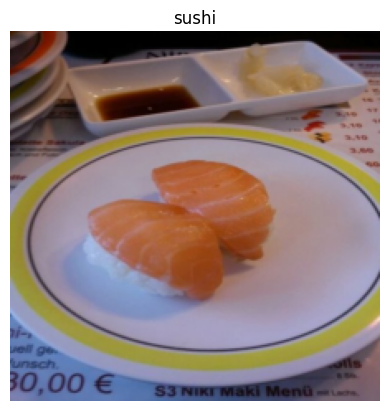

In [78]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [79]:
import torch
import torchvision
import torchvision.transforms
from torch import nn


# create EffNetB2 Model
def create_effnetb2_model(num_classes: int = 3, seed: int= 42) -> tuple[torchvision.models.efficientnet.EfficientNet,
                                                                        torchvision.transforms._presets.ImageClassification]:

  # create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # freeze base layers
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  # update classifier layer with new number of out features
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )

  return model, transforms

# create ViT Model
def create_ViT_model(num_classes: int = 3, seed: int= 42) -> tuple[torchvision.models.vision_transformer.VisionTransformer,
                                                                   torchvision.transforms._presets.ImageClassification]:
  # create vit pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # freeze base layers
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  # update classifier layer with new number of out features
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [11]:
effnetB2, effnetB2_transforms = create_effnetb2_model()
vit, vit_transforms = create_ViT_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:02<00:00, 14.2MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:16<00:00, 20.9MB/s]


In [12]:
from torchinfo import summary

summary(effnetB2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [13]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [14]:
# create data loaders
from going_modular.going_modular import data_setup

BATCH_SIZE = 32

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetB2_transforms,
                                                                                                 batch_size=BATCH_SIZE)

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=BATCH_SIZE)

print(f'EffNetB2 Train DL batch count: {len(train_dataloader_effnetb2)}, EffNetB2 Test DL batch count: {len(test_dataloader_effnetb2)}, Class Name: {class_names}',
      f'ViT Train DL batch count: {len(train_dataloader_vit)}, ViT Test DL batch count: {len(test_dataloader_vit)}, Class Name: {class_names}', sep='\n')

EffNetB2 Train DL batch count: 15, EffNetB2 Test DL batch count: 5, Class Name: ['pizza', 'steak', 'sushi']
ViT Train DL batch count: 15, ViT Test DL batch count: 5, Class Name: ['pizza', 'steak', 'sushi']


In [15]:
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
# Train EffNetB2 on GPU
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetB2.parameters(), lr=1e-3)

set_seeds()

effnetb2_results = engine.train(model=effnetB2,
                                    train_dataloader=train_dataloader_effnetb2,
                                    test_dataloader=test_dataloader_effnetb2,
                                    epochs=10,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


In [17]:
# Train ViT on GPU
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

set_seeds()

vit_results = engine.train(model=vit,
                                    train_dataloader=train_dataloader_vit,
                                    test_dataloader=test_dataloader_vit,
                                    epochs=10,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


In [80]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm



def pred_and_store(paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: list[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> list[dict]:
  pred_list = []

  for path in tqdm(paths):
    # start the time!
    start_time = timer()

    pred_dict, transformed_image = preprocess_img(path, transform, device)

    pred_prob, pred_class = make_prediction(model, transformed_image, class_names, device)

    pred_dict['pred_prob'] =  pred_prob
    pred_dict['pred_class'] = pred_class

    # stop the timer!
    end_time = timer()

    pred_dict['time_for_pred'] = round(end_time - start_time, 4)

    pred_dict['correct'] = pred_dict['class_name'] == pred_class

    pred_list.append(pred_dict)

  return pred_list


def preprocess_img(path: pathlib.Path, transform: torchvision.transforms, device: str) -> tuple[dict, torch.Tensor]:
  pred_dict = {}

  pred_dict['image_path'] = path
  pred_dict['class_name'] = path.parent.stem # name of the parent folder

  # open the image
  img = Image.open(path)

  # transform image
  transformed_image = transform(img).unsqueeze(0).to(device) # transform, add batch dimension, put it on target device

  return pred_dict, transformed_image

def make_prediction(model: torch.nn.Module,
                    transformed_image,
                    class_names: list[str],
                    device: str) -> tuple[float, str]:

  model = model.to(device)

  model.eval() # prepare model for inference

  with torch.inference_mode():
    pred_logit = model(transformed_image)
    pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediciton probablities
    pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probablity into index of prediction label
    pred_class = class_names[pred_label.cpu()] # NOTE: python variables live on the cpu

  return round(pred_prob.unsqueeze(0).max().cpu().item(), 4), pred_class

In [81]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

In [20]:
# effnetb2 predictions on cpu
effnetb2_test_preds_on_cpu = pred_and_store(paths=test_data_paths,
                                          model=effnetB2,
                                          transform=effnetB2_transforms,
                                          class_names=class_names,
                                          device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [21]:
# effnetb2 predictions on gpu
effnetb2_test_preds_on_gpu = pred_and_store(paths=test_data_paths,
                                          model=effnetB2,
                                          transform=effnetB2_transforms,
                                          class_names=class_names,
                                          device='cuda')

  0%|          | 0/150 [00:00<?, ?it/s]

In [22]:
# vit predictions on cpu
vit_test_preds_on_cpu = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [23]:
# vit predictions on gpu
vit_test_preds_on_gpu = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device='cuda')

  0%|          | 0/150 [00:00<?, ?it/s]

In [24]:
def get_avg_pred_times(data:list[dict]) -> float:
  return round(sum(d['time_for_pred'] for d in data) / len(data), 3)

print(f"EffNetB2 Average Prediction Time on CPU: {get_avg_pred_times(effnetb2_test_preds_on_cpu)}",
      f"EffNetB2 Average Prediction Time on GPU: {get_avg_pred_times(effnetb2_test_preds_on_gpu)}",
      f"ViT Average Prediction Time on CPU: {get_avg_pred_times(vit_test_preds_on_cpu)}",
      f"ViT Average Prediction Time on GPU: {get_avg_pred_times(vit_test_preds_on_gpu)}",
      sep="\n")

EffNetB2 Average Prediction Time on CPU: 0.1
EffNetB2 Average Prediction Time on GPU: 0.024
ViT Average Prediction Time on CPU: 0.523
ViT Average Prediction Time on GPU: 0.02


* Does this close the gap between them?
  Yes, making predictions on the GPU closes the gap from **0.423** to **0.004**


## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [25]:
# create transforms
food101_train_transforms = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                           vit_transforms])
food101_train_transforms, vit_transforms

(Compose(
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 )
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [26]:
# get Food101 dataset
from torchvision import datasets
from pathlib import Path

data_dir = Path('data')

food101_train_data = datasets.Food101(root=data_dir,
                              split='train',
                              transform=food101_train_transforms,
                              download=True)

food101_test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms,
                             download=True)

100%|██████████| 4996278331/4996278331 [05:02<00:00, 16506461.74it/s]


Extracting data/food-101.tar.gz to data


In [27]:
food101_class_names = food101_train_data.classes
food101_class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [82]:
# split the data
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float=0.2,
                  seed:int=42) -> tuple[torch.utils.data.dataset.Subset, torch.utils.data.dataset.Subset]:

  total = len(dataset)

  len1 = int(total * split_size)
  len2 = total - len1

  print(f'[INFO] Splitting dataset of length {len(dataset)} into splits of size: {len1} and {len2}')

  random_split_1, random_split_2 = random_split(dataset,
                                                lengths=[len1, len2],
                                                generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [29]:
train_data_food101_20_percent, _ = split_dataset(food101_train_data)
test_data_food101_20_percent, _ = split_dataset(food101_test_data)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [30]:
# create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False,
                                                                num_workers=NUM_WORKERS)

len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [32]:
vit_food101_20, vit_transforms = create_ViT_model(num_classes=101)

summary(vit_food101_20,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [33]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit_food101_20.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) #label_smoothing helps against overfitting

set_seeds()

vit_food101_20_results = engine.train(model=vit_food101_20,
                                      train_dataloader=train_dataloader_food101_20_percent,
                                      test_dataloader=test_dataloader_food101_20_percent,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


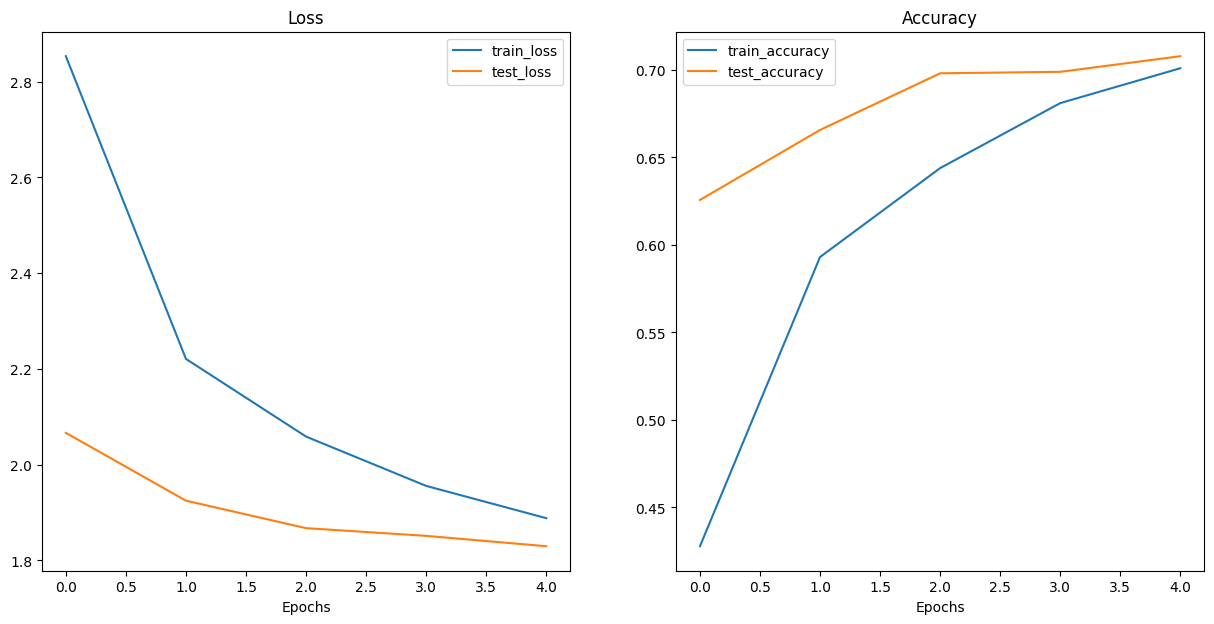

In [34]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_food101_20_results)

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [44]:
from tqdm.auto import tqdm

# get a single batch
batch = next(iter(test_dataloader_food101_20_percent))

# set the device
vit_food101_20 = vit_food101_20.to(device)

vit_food101_20.eval()

vit_food101_20_preds = []

X_batch, y_batch = batch

X_batch, y_batch = X_batch.to(device), y_batch.to(device)

for X, y in tqdm(zip(X_batch, y_batch), total=len(X_batch)):
  prediction = {}

  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20(X.unsqueeze(0)), dim=1) # add batch dimension
    pred_labels = torch.argmax(pred_probs, dim=1)

    prediction['pred_prob'] = torch.max(pred_probs).cpu().numpy()
    prediction['pred_label'] = pred_labels.cpu().numpy()[0]
    prediction['label'] = y.cpu().numpy()

  vit_food101_20_preds.append(prediction)

  0%|          | 0/32 [00:00<?, ?it/s]

In [49]:
import pandas as pd

df_pred_food101_20 = pd.DataFrame(vit_food101_20_preds)

df_pred_food101_20['pred_class'] = df_pred_food101_20['pred_label'].apply(lambda x: food101_class_names[x])
df_pred_food101_20['label_class'] = df_pred_food101_20['label'].apply(lambda x: food101_class_names[x])
df_pred_food101_20['is_correct'] = df_pred_food101_20['pred_label'] == df_pred_food101_20['label']

df_pred_food101_20.head()

,pred_prob,pred_label,label,pred_class,label_class,is_correct
0,0.7962381,72,72,pancakes,pancakes,True
1,0.6283233,57,57,hummus,hummus,True
2,0.19211605,80,80,pulled_pork_sandwich,pulled_pork_sandwich,True
3,0.57428443,51,51,guacamole,guacamole,True
4,0.8206848,1,1,baby_back_ribs,baby_back_ribs,True


In [50]:
# get top wrong
df_pred_food101_20[df_pred_food101_20['is_correct'] == False][:5]

,pred_prob,pred_label,label,pred_class,label_class,is_correct
5,0.19642015,59,79,lasagna,prime_rib,False
15,0.5403365,98,22,tiramisu,chocolate_mousse,False
21,0.27671245,48,50,greek_salad,grilled_salmon,False
23,0.30750173,48,13,greek_salad,caprese_salad,False
24,0.16533129,0,47,apple_pie,gnocchi,False


Looking at chocolate_mousse being mistaken for tiramisu with a prediction probability of ~ 54%.  They both potentially look the same.

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [51]:
# create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader_food101 = torch.utils.data.DataLoader(dataset=food101_train_data,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)

test_dataloader_food101 = torch.utils.data.DataLoader(dataset=food101_test_data,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)

len(train_dataloader_food101), len(test_dataloader_food101)

(2368, 790)

In [52]:
vit_food101, vit_transforms = create_ViT_model(num_classes=101)

summary(vit_food101,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [53]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit_food101.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) #label_smoothing helps against overfitting

set_seeds()

vit_food101_results = engine.train(model=vit_food101,
                                   train_dataloader=train_dataloader_food101,
                                   test_dataloader=test_dataloader_food101,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=5,
                                   device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3353 | train_acc: 0.5628 | test_loss: 1.7649 | test_acc: 0.7238
Epoch: 2 | train_loss: 2.0375 | train_acc: 0.6509 | test_loss: 1.6971 | test_acc: 0.7478
Epoch: 3 | train_loss: 1.9765 | train_acc: 0.6694 | test_loss: 1.6777 | test_acc: 0.7513
Epoch: 4 | train_loss: 1.9367 | train_acc: 0.6847 | test_loss: 1.6755 | test_acc: 0.7572
Epoch: 5 | train_loss: 1.9176 | train_acc: 0.6901 | test_loss: 1.6826 | test_acc: 0.7547


* Does it beat the original Food101 paper's best result of 56.4% accuracy?
  A lot higher from the first Epoch!  It took forever though.

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

[Label-Retrieval-Augmented Diffusion Models for Learning from Noisy Labels](https://paperswithcode.com/paper/label-retrieval-augmented-diffusion-models-1)

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?



*   **(As mentioned above) Someone uploading an image that is not food.**
  - We can update any of the predictions with  a "Not Food/Unknown" label if the total of predictions is under a threshold like, 30%.
*   **The model could Fail on picking the correct label.**  
  - No model is perfect so there is a chance of mis-labelling of course.
* **Timing out when trying to make a prediciton.  There are a lot of moving parts so potential of a timeout or network error happening is there.**
  - All uknown errors should be handled gracefully.



## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [269]:
# create MNasNet Model
def create_mnasnet_model(num_classes: int = 3, seed: int= 42) -> tuple[torchvision.models.mnasnet.MNASNet,
                                                                       torchvision.transforms._presets.ImageClassification]:

  weights = torchvision.models.MNASNet1_0_Weights.DEFAULT
  transforms = torchvision.models.MNASNet1_0_Weights.IMAGENET1K_V1.transforms()
  model = torchvision.models.mnasnet1_0(weights=weights)

  # freeze base layers
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  # update classifier layer with new number of out features
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=num_classes, bias=True)
  )

  return model, transforms

In [270]:
mnastnet_20, mnasnet_transforms = create_MNasNet_model(num_classes=37)

In [271]:
from torchinfo import summary

summary(mnastnet_20,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MNASNet (MNASNet)                             [1, 3, 224, 224]     [1, 37]              --                   Partial
├─Sequential (layers)                         [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    └─BatchNorm2d (1)                        [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    └─ReLU (2)                               [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Conv2d (3)                             [1, 32, 112, 112]    [1, 32, 112, 112]    (288)                False
│    └─BatchNorm2d (4)                        [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    └─ReLU (5)                               [1, 32, 112, 112]    [1, 32, 11

In [272]:
mnasnet_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [273]:
import os
import shutil

# Define the path to the dataset
dataset_path = '/content/data/oxford-iiit-pet'

# Remove the dataset directory if it exists
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

In [274]:
# Get Flowers102 Dataset
from torchvision import datasets
from pathlib import Path

data_dir = Path('data')

pet_train_data = datasets.OxfordIIITPet(root=data_dir,
                                        split="trainval",
                                        transform=mnasnet_transforms,
                                        target_types = 'category',
                                        download=True)

pet_test_data = datasets.OxfordIIITPet(root=data_dir,
                             split="test",
                             transform=mnasnet_transforms,
                             target_types = 'category',
                             download=True)

100%|██████████| 791918971/791918971 [01:03<00:00, 12539711.00it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 6454750.63it/s] 


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [275]:
class_names = pet_train_data.classes
class_names[:5], len(class_names)

(['Abyssinian',
  'American Bulldog',
  'American Pit Bull Terrier',
  'Basset Hound',
  'Beagle'],
 37)

In [276]:
train_data_pet_20_percent, _ = split_dataset(pet_train_data)
test_data_pet_20_percent, _ = split_dataset(pet_test_data)

[INFO] Splitting dataset of length 3680 into splits of size: 736 and 2944
[INFO] Splitting dataset of length 3669 into splits of size: 733 and 2936


In [277]:
from torch.utils.data import DataLoader
# create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader_pet_20 = torch.utils.data.DataLoader(dataset=train_data_pet_20_percent,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)

test_dataloader_pet_20 = torch.utils.data.DataLoader(dataset=test_data_pet_20_percent,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)

len(train_dataloader_pet_20), len(test_dataloader_pet_20)

(23, 23)

In [278]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader_pet_20))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(9))

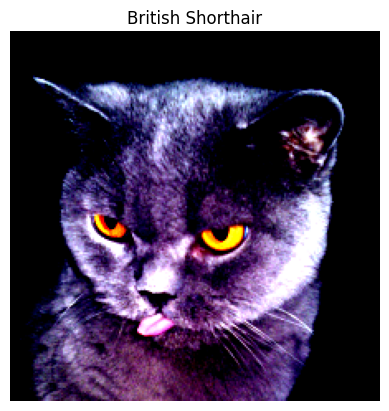

In [279]:
import matplotlib.pyplot as plt

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label].title())
plt.axis(False);

In [280]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=mnastnet_20.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.001)
set_seeds()

mnastnet_20_results = engine.train(model=mnastnet_20,
                                   train_dataloader=train_dataloader_pet_20,
                                   test_dataloader=test_dataloader_pet_20,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=10,
                                   device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2029 | train_acc: 0.2052 | test_loss: 2.4440 | test_acc: 0.4967
Epoch: 2 | train_loss: 2.0543 | train_acc: 0.6984 | test_loss: 1.6644 | test_acc: 0.6481
Epoch: 3 | train_loss: 1.3963 | train_acc: 0.8573 | test_loss: 1.2501 | test_acc: 0.7121
Epoch: 4 | train_loss: 1.0051 | train_acc: 0.9035 | test_loss: 1.0314 | test_acc: 0.7477
Epoch: 5 | train_loss: 0.7706 | train_acc: 0.9511 | test_loss: 0.9270 | test_acc: 0.7543
Epoch: 6 | train_loss: 0.6057 | train_acc: 0.9701 | test_loss: 0.8296 | test_acc: 0.7803
Epoch: 7 | train_loss: 0.5008 | train_acc: 0.9660 | test_loss: 0.7908 | test_acc: 0.7816
Epoch: 8 | train_loss: 0.4255 | train_acc: 0.9755 | test_loss: 0.7403 | test_acc: 0.7925
Epoch: 9 | train_loss: 0.3648 | train_acc: 0.9864 | test_loss: 0.7213 | test_acc: 0.7884
Epoch: 10 | train_loss: 0.3158 | train_acc: 0.9891 | test_loss: 0.7082 | test_acc: 0.7803


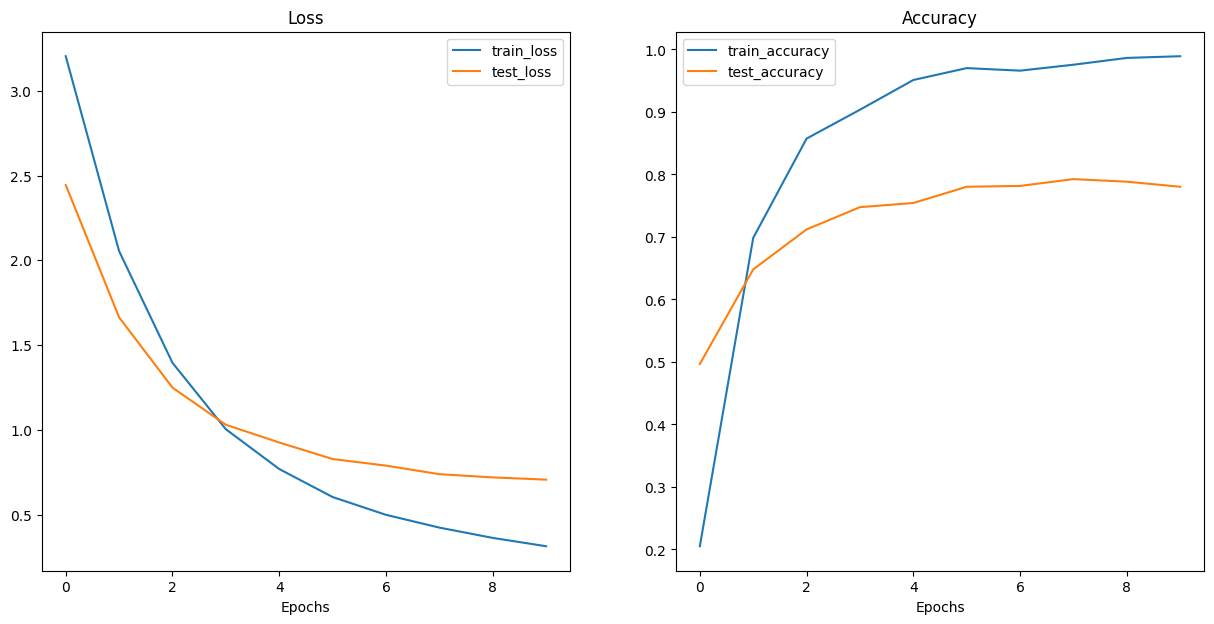

In [281]:
from helper_functions import plot_loss_curves

plot_loss_curves(mnastnet_20_results)

Oh no! Overfitting :-(

In [282]:
mnastnet, mnasnet_transforms = create_MNasNet_model(num_classes=37)

In [283]:
from torchinfo import summary

summary(mnastnet,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MNASNet (MNASNet)                             [1, 3, 224, 224]     [1, 37]              --                   Partial
├─Sequential (layers)                         [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    └─BatchNorm2d (1)                        [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    └─ReLU (2)                               [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Conv2d (3)                             [1, 32, 112, 112]    [1, 32, 112, 112]    (288)                False
│    └─BatchNorm2d (4)                        [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    └─ReLU (5)                               [1, 32, 112, 112]    [1, 32, 11

In [284]:
mnasnet_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    mnasnet_transforms,
])

mnasnet_train_transforms, mnasnet_transforms

(Compose(
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 )
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [234]:
import os
import shutil

# Define the path to the dataset
dataset_path = '/content/data/oxford-iiit-pet'

# Remove the dataset directory if it exists
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

In [285]:
# Get Flowers102 Dataset
from torchvision import datasets
from pathlib import Path

data_dir = Path('data')

pet_train_data = datasets.OxfordIIITPet(root=data_dir,
                                        split="trainval",
                                        transform=mnasnet_train_transforms,
                                        target_types = 'category',
                                        download=True)

pet_test_data = datasets.OxfordIIITPet(root=data_dir,
                             split="test",
                             transform=mnasnet_transforms,
                             target_types = 'category',
                             download=True)

In [287]:
from torch.utils.data import DataLoader
# create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader_pet = torch.utils.data.DataLoader(dataset=pet_train_data,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)

test_dataloader_pet = torch.utils.data.DataLoader(dataset=pet_test_data,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)

len(train_dataloader_pet), len(test_dataloader_pet)

(115, 115)

In [288]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=mnastnet.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.5)
set_seeds()

mnastnet_results = engine.train(model=mnastnet,
                                   train_dataloader=train_dataloader_pet,
                                   test_dataloader=test_dataloader_pet,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=10,
                                   device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1546 | train_acc: 0.5168 | test_loss: 2.8881 | test_acc: 0.8100
Epoch: 2 | train_loss: 2.9116 | train_acc: 0.7628 | test_loss: 2.8526 | test_acc: 0.8519
Epoch: 3 | train_loss: 2.8747 | train_acc: 0.7829 | test_loss: 2.8325 | test_acc: 0.8595
Epoch: 4 | train_loss: 2.8497 | train_acc: 0.8027 | test_loss: 2.8249 | test_acc: 0.8576
Epoch: 5 | train_loss: 2.8448 | train_acc: 0.8054 | test_loss: 2.8289 | test_acc: 0.8644
Epoch: 6 | train_loss: 2.8338 | train_acc: 0.8130 | test_loss: 2.8043 | test_acc: 0.8777
Epoch: 7 | train_loss: 2.8259 | train_acc: 0.8285 | test_loss: 2.8040 | test_acc: 0.8796
Epoch: 8 | train_loss: 2.8223 | train_acc: 0.8272 | test_loss: 2.8168 | test_acc: 0.8671
Epoch: 9 | train_loss: 2.8140 | train_acc: 0.8348 | test_loss: 2.7898 | test_acc: 0.8796
Epoch: 10 | train_loss: 2.8083 | train_acc: 0.8364 | test_loss: 2.7946 | test_acc: 0.8753


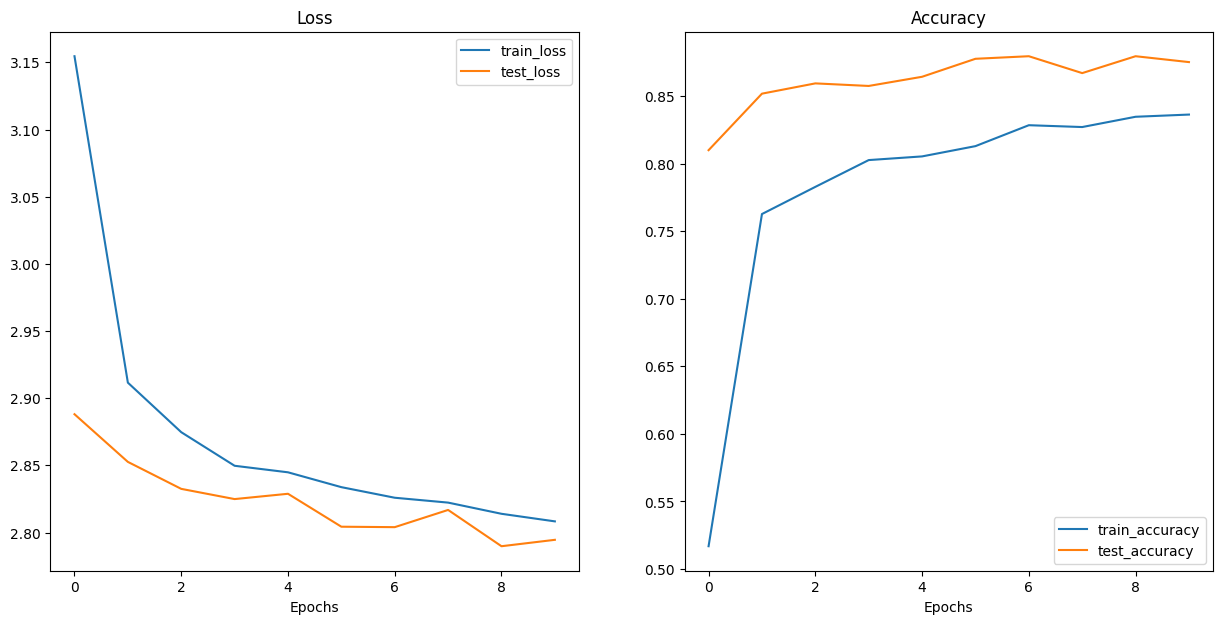

In [289]:
plot_loss_curves(mnastnet_results)

In [239]:
from pathlib import Path

models_path = Path('models')

models_path.mkdir(parents=True, exist_ok=True)

In [290]:
from going_modular.going_modular import utils

# Create a model path
mnastnet_pet_model_path = "mnastnet_pet_feature_extractor.pth"

# Save PetVision model
utils.save_model(model=mnastnet,
                 target_dir="models/",
                 model_name=mnastnet_pet_model_path)

[INFO] Saving model to: models/mnastnet_pet_feature_extractor.pth


In [291]:
from pathlib import PurePath

# Get the model size in bytes then convert to megabytes
mnastnet_model_size = Path('models', mnastnet_pet_model_path).stat().st_size // (1024*1024)
print(f"MNASNet Pet feature extractor model size: {mnastnet_model_size} MB")

MNASNet Pet feature extractor model size: 12 MB


In [242]:
len(class_names)

37

Creating an outline for our PetVision app:

```
demos/
  petvision/
    mnastnet_pet_feature_extractor.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [243]:
from pathlib import Path

# Create PetVision demo path
pet_vision_demo_path = Path('demos/pet_vision/')

# Make Pet_Vision demo directory
pet_vision_demo_path.mkdir(parents=True, exist_ok=True)

# Make Pet_Vision demo examples directory
(pet_vision_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [244]:
!ls demos/pet_vision/

examples


In [247]:
import requests
import os

def download_custom_img(github_path: str, name: str) -> None:

  custom_images_root = "/content/demos/pet_vision"
  full_path = os.path.join(custom_images_root, 'examples')

  if os.path.isdir(full_path):
      print(f"{full_path} directory exists, skipping re-download.")
  else:
      print(f"Did not find {full_path}, creating it...")
      os.makedirs(full_path, exist_ok=True)

  custom_image_path = os.path.join(full_path, name)

  if not os.path.isfile(custom_image_path):
    with open(custom_image_path, "wb") as f:
      request = requests.get(github_path)
      print(f"Downloading {custom_image_path}...")
      f.write(request.content)
  else:
      print(f"{custom_image_path} already exists, skipping download...")

In [249]:
download_custom_img(github_path="https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/Russian_Blue.jpeg", name="Russian_Blue.jpeg")

download_custom_img(github_path="https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/shiba.jpeg", name="shiba.jpeg")

download_custom_img(github_path="https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/boxer.jpg", name="boxer.jpeg")

download_custom_img(github_path="https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/sphynx-cat.jpg", name="sphynx.jpeg")

download_custom_img(github_path="https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/japanese-chin-breed.jpg", name="japanese_chin.jpeg")

/content/demos/pet_vision/examples directory exists, skipping re-download.
/content/demos/pet_vision/examples directory exists, skipping re-download.
/content/demos/pet_vision/examples directory exists, skipping re-download.
/content/demos/pet_vision/examples directory exists, skipping re-download.
/content/demos/pet_vision/examples directory exists, skipping re-download.


In [295]:
import os

pet_vision_demo_path = Path('demos/pet_vision/examples')

# Get example filepaths in a list of lists
example_list = [['examples/' + entry.name] for entry in os.scandir(pet_vision_demo_path) if entry.is_file()]

example_list

[['examples/japanese_chin.jpeg'],
 ['examples/shiba.jpeg'],
 ['examples/boxer.jpeg'],
 ['examples/sphynx.jpeg'],
 ['examples/Russian_Blue.jpeg']]

In [293]:
!mv models/mnastnet_pet_feature_extractor.pth demos/pet_vision/

In [294]:
class_names[:10]

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair']

In [266]:
# Create path to Pet class names
pet_vision_class_names_path = 'demos/pet_vision/class_names.txt'

with open(pet_vision_class_names_path, 'w') as f:
  print(f"[INFO] Saving Pet class names to {pet_vision_class_names_path}")
  f.write("\n".join(class_names)) # new line per class name

[INFO] Saving Pet class names to demos/pet_vision/class_names.txt


In [267]:
%%writefile demos/pet_vision/model.py

import torch
import torchvision
import torchvision.models.efficientnet
import torchvision.transforms
from torch import nn

# create MNasNet Model
def create_MNasNet_model(num_classes: int = 3, seed: int= 42) -> tuple[torchvision.models.mnasnet.MNASNet,
                                                                       torchvision.transforms._presets.ImageClassification]:

  weights = torchvision.models.MNASNet1_0_Weights.DEFAULT
  transforms = torchvision.models.MNASNet1_0_Weights.IMAGENET1K_V1.transforms()
  model = torchvision.models.mnasnet1_0(weights=weights)

  # freeze base layers
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  # update classifier layer with new number of out features
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=num_classes, bias=True)
  )

  return model, transforms

Writing demos/pet_vision/model.py


In [297]:
%%writefile demos/pet_vision/app.py

import gradio as gr
import os
import torch

from model import create_MNasNet_model
from timeit import default_timer as timer

# setup class names
with open('class_names.txt', 'r') as f:
    class_names = [pet_name.strip() for pet_name in f.readlines()]

# model and transforms prep
mnastnet, mnasnet_transforms = create_MNasNet_model(num_classes=len(class_names))

# load saved weights
mnastnet.load_state_dict(
    torch.load(
        f='mnastnet_pet_feature_extractor.pth',
        map_location=torch.device('cpu') #load the model to the cpu
    )
)

# predict function
def predict(img) -> tuple[dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with MNasNet
  img = mnasnet_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  mnastnet.eval()

  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(mnastnet(img), dim=1)


  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

  import gradio as gr

# Create example list
example_list = [['examples/' + entry.name] for entry in os.scandir('examples') if entry.is_file()]

# Gradio app demo

# Create title, description and article
title = 'What My Breed? 🐶🐈'
description = 'An [MNASNet 1_0 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.mnasnet1_0.html#torchvision.models.mnasnet1_0) computer vision model to classify [37 classes of food from the OxfordIIIPet dataset](https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/pet_class_names.txt).'
article = 'Created at [PyTorch Model Deployment](https://github.com/AishaEvering/PyTorch_Exercises/blob/main/09_pytorch_model_deployment_exercises.ipynb).'

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (seconds)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!!!!
demo.launch()


Writing demos/pet_vision/app.py


In [299]:
%%writefile demos/pet_vision/requirements.txt
torch==2.3.1
torchvision==0.18.1
gradio==4.36.1

Writing demos/pet_vision/requirements.txt


In [300]:
# Change into the pet_vision directory and then zip it from the inside
!cd demos/pet_vision && zip -r ../pet_vision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 38%)
  adding: examples/ (stored 0%)
  adding: examples/japanese_chin.jpeg (deflated 80%)
  adding: examples/shiba.jpeg (deflated 80%)
  adding: examples/boxer.jpeg (deflated 80%)
  adding: examples/sphynx.jpeg (deflated 80%)
  adding: examples/Russian_Blue.jpeg (deflated 83%)
  adding: mnastnet_pet_feature_extractor.pth (deflated 6%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 6%)


In [301]:
# Download
try:
  from google.colab import files
  files.download('demos/pet_vision.zip')
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), \
  please download pet_vision.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>